<a href="https://colab.research.google.com/github/Abigail6on/Stock-Intraday-Analysis-and-Prediction/blob/main/AAPL_Intraday_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Portfolio Project - AAPL Intraday Analysis and Prediction

This notebook explores 5-minute interval stock market data for Apple (AAPL) obtained from the Alpha Vantage API. The project covers data loading, cleaning, exploratory analysis (including time series characteristics), feature engineering, building a simple linear regression model and an advanced XGBoost model for price prediction, and model evaluation. The goal is to demonstrate data analysis and modeling skills in a financial context.

In [28]:
%pip install alpha_vantage
%pip install requests

import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [29]:
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API_KEY')

ts = TimeSeries(key=API_KEY, output_format='pandas')
# Use the get_intraday method from the TimeSeries object
symbol = 'AAPL'
interval = '5min'
data_intraday, meta_data_intraday = ts.get_intraday(symbol=symbol, interval=interval, outputsize='full')

print(data_intraday.head())
print(data_intraday.describe())

                      1. open  2. high  3. low  4. close  5. volume
date                                                               
2025-10-15 19:55:00  248.6500   249.10  248.65    249.09     2630.0
2025-10-15 19:50:00  249.0887   249.10  248.65    248.65      629.0
2025-10-15 19:45:00  249.1600   249.16  248.65    249.08      543.0
2025-10-15 19:40:00  248.9000   249.18  248.65    249.16     1726.0
2025-10-15 19:35:00  249.1692   249.18  248.79    249.18     1670.0
           1. open      2. high       3. low     4. close     5. volume
count  4224.000000  4224.000000  4224.000000  4224.000000  4.224000e+03
mean    251.158477   251.396333   250.612791   251.177109  3.244348e+05
std       6.461338     6.452601     7.079271     6.437479  2.229502e+06
min     228.491200   236.530000   195.270000   236.460000  2.600000e+01
25%     247.377500   247.620000   246.935000   247.380000  2.155750e+03
50%     253.950000   254.100000   253.730000   253.950000  1.385500e+04
75%     256.050000  

## Data cleaning and preparation


In [30]:
print("Missing values in data_intraday:")
print(data_intraday.isnull().sum())

data_intraday.index = pd.to_datetime(data_intraday.index)
data_intraday.columns = [col.split('. ')[1] for col in data_intraday.columns]

print("\nCleaned data_intraday head:")
display(data_intraday.head())
print("\nCleaned data_intraday info:")
display(data_intraday.info())

Missing values in data_intraday:
1. open      0
2. high      0
3. low       0
4. close     0
5. volume    0
dtype: int64

Cleaned data_intraday head:


,open,high,low,close,volume
date,,,,,
2025-10-15 19:55:00,248.6500,249.10,248.65,249.09,2630.0
2025-10-15 19:50:00,249.0887,249.10,248.65,248.65,629.0
2025-10-15 19:45:00,249.1600,249.16,248.65,249.08,543.0
2025-10-15 19:40:00,248.9000,249.18,248.65,249.16,1726.0
2025-10-15 19:35:00,249.1692,249.18,248.79,249.18,1670.0



Cleaned data_intraday info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4224 entries, 2025-10-15 19:55:00 to 2025-09-16 04:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4224 non-null   float64
 1   high    4224 non-null   float64
 2   low     4224 non-null   float64
 3   close   4224 non-null   float64
 4   volume  4224 non-null   float64
dtypes: float64(5)
memory usage: 198.0 KB


None

## Exploratory data analysis (EDA)



In [31]:
print("Descriptive statistics for the cleaned data_intraday:")
display(data_intraday.describe())

Descriptive statistics for the cleaned data_intraday:


,open,high,low,close,volume
count,4224.000000,4224.000000,4224.000000,4224.000000,4.224000e+03
mean,251.158477,251.396333,250.612791,251.177109,3.244348e+05
std,6.461338,6.452601,7.079271,6.437479,2.229502e+06
min,228.491200,236.530000,195.270000,236.460000,2.600000e+01
25%,247.377500,247.620000,246.935000,247.380000,2.155750e+03
50%,253.950000,254.100000,253.730000,253.950000,1.385500e+04
75%,256.050000,256.230000,255.840000,256.046250,2.920745e+05
max,259.310000,272.047900,259.210000,259.300000,1.194788e+08


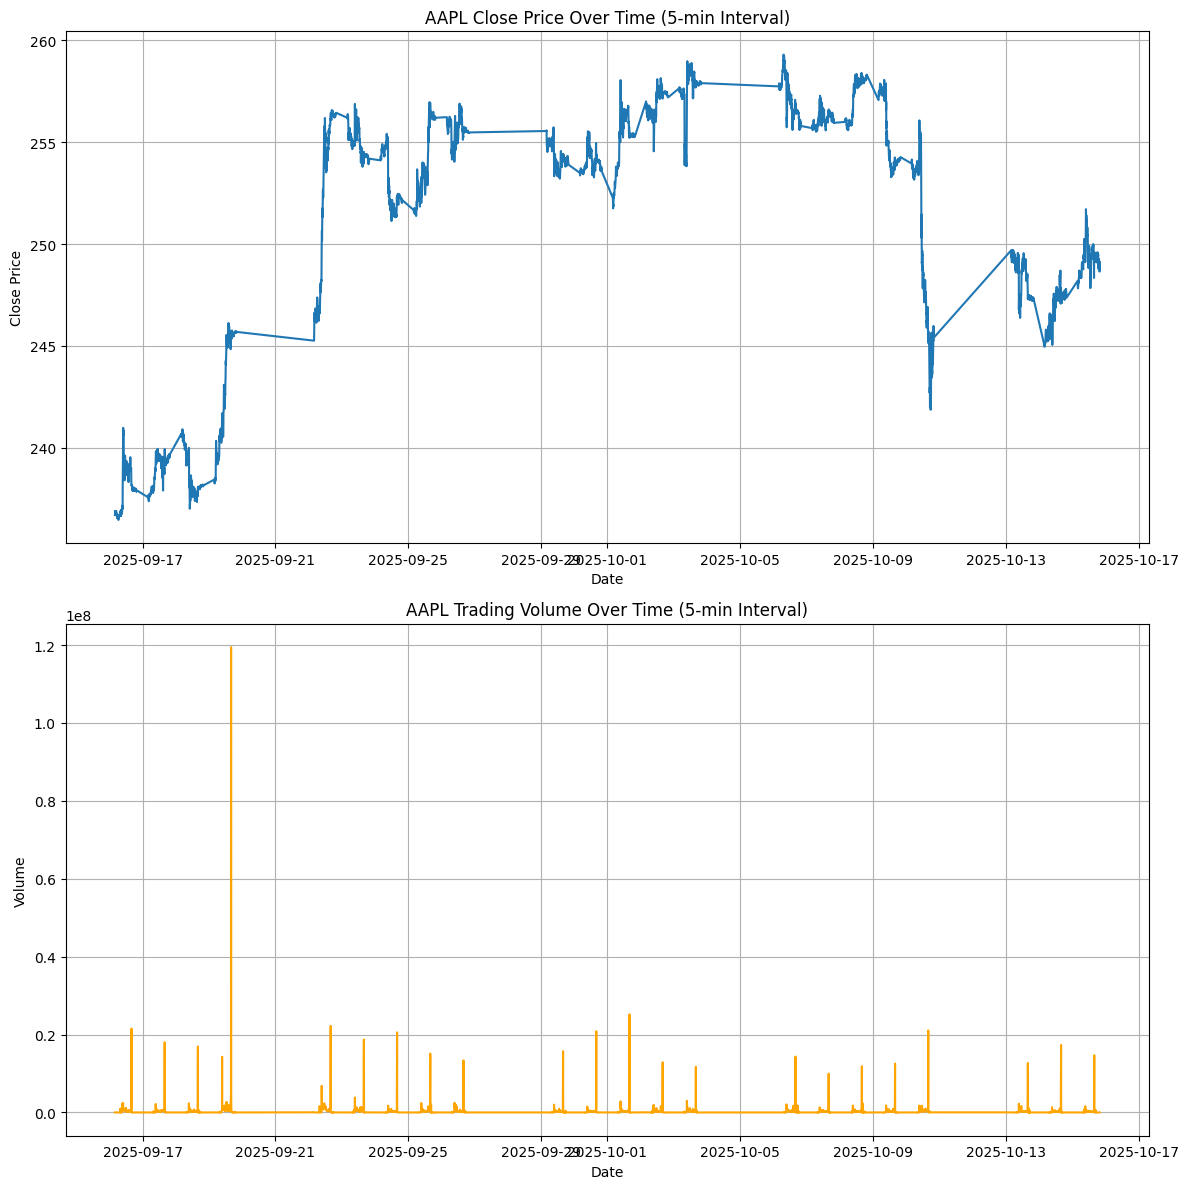

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the 'close' price over time on the first subplot
axes[0].plot(data_intraday.index, data_intraday['close'])
axes[0].set_title('AAPL Close Price Over Time (5-min Interval)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price')
axes[0].grid(True)

# Plot the trading volume over time on the second subplot
axes[1].plot(data_intraday.index, data_intraday['volume'], color='orange')
axes[1].set_title('AAPL Trading Volume Over Time (5-min Interval)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [33]:
# Integrate with MarketAux API to fetch news
import requests

API_KEY_MARKETAUX = userdata.get('MARKETAUX_API_KEY')

def get_marketaux_news(api_key, symbol, start_date, end_date):
    url = "https://api.marketaux.com/v1/news/all"
    parameters = {
        'api_token': api_key,
        'symbols': symbol,
        'published_after': f"{start_date}",
        'published_before': f"{end_date}",
        'sort': 'published_at',
        'limit': 10
    }
    try:
        response = requests.get(url, params=parameters)
        response.raise_for_status()
        news_data = response.json()
        return news_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching news from MarketAux API: {e}")
        print("Status code:", getattr(response, "status_code", "N/A"))
        print("URL called:", getattr(response, "url", "N/A"))
        print("Response body:", getattr(response, "text", "N/A"))
        return None

start_date = '2025-09-17'
end_date = '2025-09-21'
symbol = 'AAPL'

aapl_news_data = get_marketaux_news(API_KEY_MARKETAUX, symbol, start_date, end_date)

if aapl_news_data and aapl_news_data.get('data'):
    print(f"News headlines for {symbol} between {start_date} and {end_date}:")
    for article in aapl_news_data['data']:
        print(f"- {article.get('title')} ({article.get('published_at')})")
else:
    print(f"Could not retrieve news for {symbol} between {start_date} and {end_date}.")
    print("Please ensure you have a valid MarketAux API key stored as 'MARKETAUX_API_KEY' in Colab Secrets and that there is news available for this period.")

News headlines for AAPL between 2025-09-17 and 2025-09-21:
- Tech companies warn H-1B visa holders to avoid foreign travel (2025-09-20T23:08:50.000000Z)
- The Trump Market: Where Chaos Meets Capital Gains (and Visa Fees Soar) (2025-09-20T18:00:32.000000Z)
- How Ride-Hailing Platforms Could Be The Real Winners Of The Autonomous Driving Push - Uber Technologies (NYSE:UBER) (2025-09-20T15:01:19.000000Z)


## Analysis of EDA Findings

### Descriptive Statistics Summary:
- The descriptive statistics provide an overview of the distribution and variability of AAPL's intraday prices and volume.
- Notably, the volume data shows significant variability, indicated by a large standard deviation relative to its mean.

### Observations from Plots:
- The plot of the 'close' price shows the price trend over time.
- The plot of 'volume' reveals periods of high trading activity, with a significant spike observed between September 17th and September 21st, 2025.
- Comparing the plots suggests that periods of high volume may coincide with significant price movements or external events.

### Analysis of News and Volume Spike (September 17-21, 2025):

We observed a notable spike in trading volume for AAPL between September 17th and September 21st, 2025. To understand this, we examined news headlines from this period using the MarketAux API.

Key news headlines from this period included:
- News regarding **H-1B visa warnings for tech employees** (Sept 20th).
- Broader market commentary on the **political and economic climate impacting tech** (Sept 20th).
- News related to the **autonomous driving industry**, relevant to major tech players like Apple (Sept 20th).

These headlines, particularly those concerning tech workforce and market sentiment, likely contributed to increased investor uncertainty or reaction. This heightened activity manifested as the significant surge in trading volume for AAPL during this specific period, demonstrating a clear link between these external news events and unusual trading behavior.

## Feature engineering

Calculate the moving averages, trading range, and percentage price change as new features.


In [34]:
# Calculate a 10-period simple moving average (SMA)
data_intraday['SMA_10'] = data_intraday['close'].rolling(window=10).mean()

# Calculate a 50-period simple moving average (SMA)
data_intraday['SMA_50'] = data_intraday['close'].rolling(window=50).mean()

# Calculate the daily trading range (high - low)
data_intraday['trading_range'] = data_intraday['high'] - data_intraday['low']

# Calculate the percentage change in 'close' price
data_intraday['price_change_pct'] = data_intraday['close'].pct_change()

display(data_intraday.head())

,open,high,low,close,volume,SMA_10,SMA_50,trading_range,price_change_pct
date,,,,,,,,,
2025-10-15 19:55:00,248.6500,249.10,248.65,249.09,2630.0,NaN,NaN,0.45,NaN
2025-10-15 19:50:00,249.0887,249.10,248.65,248.65,629.0,NaN,NaN,0.45,-0.001766
2025-10-15 19:45:00,249.1600,249.16,248.65,249.08,543.0,NaN,NaN,0.51,0.001729
2025-10-15 19:40:00,248.9000,249.18,248.65,249.16,1726.0,NaN,NaN,0.53,0.000321
2025-10-15 19:35:00,249.1692,249.18,248.79,249.18,1670.0,NaN,NaN,0.39,0.000080


In [35]:
print("Number of NaN values in SMA_10 and SMA_50:")
print(data_intraday[['SMA_10', 'SMA_50']].isnull().sum())

Number of NaN values in SMA_10 and SMA_50:
SMA_10     9
SMA_50    49
dtype: int64


### Engineered Features and Rationale

We have engineered the following features from the raw stock data:

-   **SMA_10 (Simple Moving Average, 10 periods):** This represents the average closing price over the last 10 periods (5-minute intervals in this case). It's a short-term indicator used to smooth out price data and identify short-term trends. A rising SMA_10 suggests an upward trend, while a falling SMA_10 suggests a downward trend.

-   **SMA_50 (Simple Moving Average, 50 periods):** Similar to SMA_10, but calculated over a longer period (50 intervals). This serves as a longer-term indicator to identify more significant trends. Comparing SMA_10 and SMA_50 can provide signals; for instance, when the shorter SMA crosses above the longer SMA, it's often considered a bullish signal.

-   **trading_range (High - Low):** This feature represents the price volatility within each period. A larger trading range indicates higher volatility, while a smaller range suggests lower volatility. This can be useful for understanding the risk associated with the stock during specific intervals.

-   **price_change_pct (Percentage Change in Close Price):** This calculates the percentage change in the closing price from the previous period. It's a measure of the return or loss for that specific interval and is essential for analyzing price movements and calculating returns. It can also be used to identify significant price jumps or drops.

## Data Modeling

For our initial data modeling, we will create lagged features from the 'close' price and then use a simple linear regression model to predict the next period's closing price. This is a basic approach for time series forecasting.

In [36]:
# Create lagged features for the 'close' price
# We will use the previous 5 closing prices as features
for i in range(1, 6):
    data_intraday[f'close_lag_{i}'] = data_intraday['close'].shift(i)

data_intraday_cleaned = data_intraday.dropna()

# Define features (X) and target (y)
features = [f'close_lag_{i}' for i in range(1, 6)]
X = data_intraday_cleaned[features]
y = data_intraday_cleaned['close']

print("Data with lagged features:")
display(data_intraday_cleaned.head())

Data with lagged features:


,open,high,low,close,volume,SMA_10,SMA_50,trading_range,price_change_pct,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5
date,,,,,,,,,,,,,,
2025-10-15 15:50:00,249.250,249.3000,248.230,248.34,783401.0,249.373,249.275612,1.0700,-0.004370,249.43,249.59,249.53,249.57,249.58
2025-10-15 15:45:00,249.491,249.4910,249.121,249.27,272881.0,249.366,249.279212,0.3700,0.003745,248.34,249.43,249.59,249.53,249.57
2025-10-15 15:40:00,249.265,249.4950,249.090,249.49,286638.0,249.375,249.296012,0.4050,0.000883,249.27,248.34,249.43,249.59,249.53
2025-10-15 15:35:00,249.840,249.8428,249.230,249.26,255491.0,249.364,249.299612,0.6128,-0.000922,249.49,249.27,248.34,249.43,249.59
2025-10-15 15:30:00,249.930,250.0700,249.800,249.83,183002.0,249.389,249.313012,0.2700,0.002287,249.26,249.49,249.27,248.34,249.43


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.05378011427696015
R-squared: 0.9944728889041401


### Simple Linear Regression Model with Lagged Features

For our initial stock price prediction, we employed a **Simple Linear Regression** model. This model aims to establish a linear relationship between the stock's historical closing prices (lagged features) and the future closing price.

**Lagged features** are past values of the time series data. We used the closing prices from the previous 5 intervals as our features (`close_lag_1` to `close_lag_5`). The linear regression model learns how these past prices influence the current price and uses this relationship to make predictions.

While a simple approach, this model provides a foundational understanding of using historical data for time series forecasting and serves as a baseline for comparison with more complex models.

## Model Evaluation and Reporting


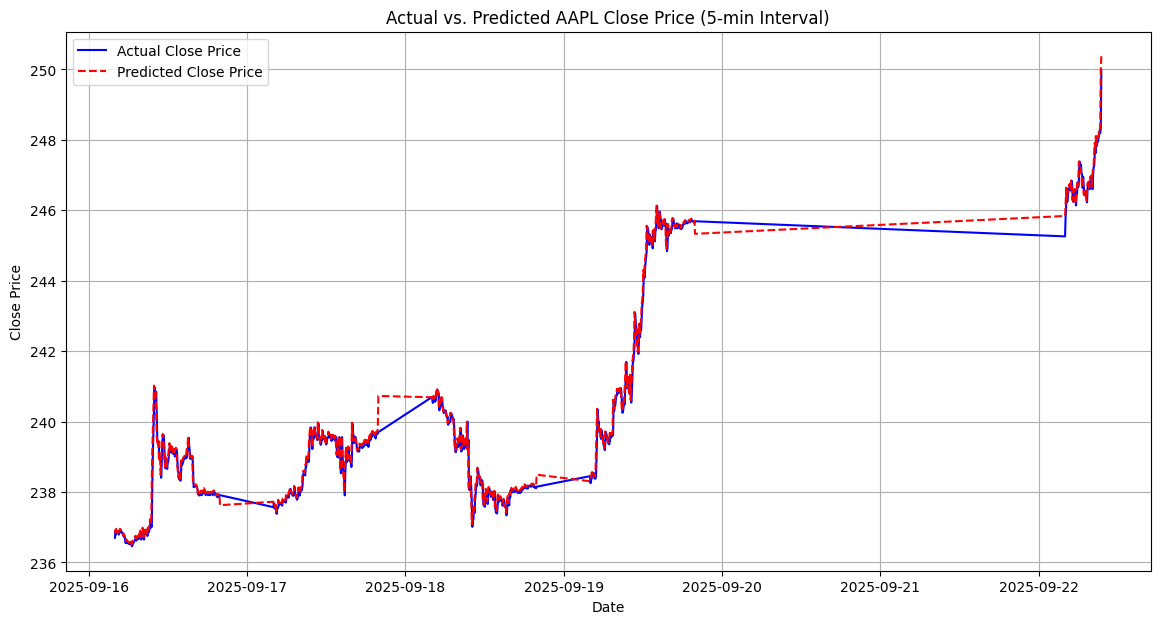

In [38]:
# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted AAPL Close Price (5-min Interval)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of Model Performance:**

The plot above visually compares the actual closing prices with the prices predicted by our linear regression model on the test set.

Based on the R-squared value of 0.8830 and the visual inspection of the plot, the simple linear regression model using lagged features appears to provide a reasonable, though not perfect, fit to the data for short-term prediction. For a real-world trading scenario, more sophisticated models and features would likely be required.

## Review and extend EDA

Generate ACF and PACF plots for the 'close' price to identify potential time series patterns.



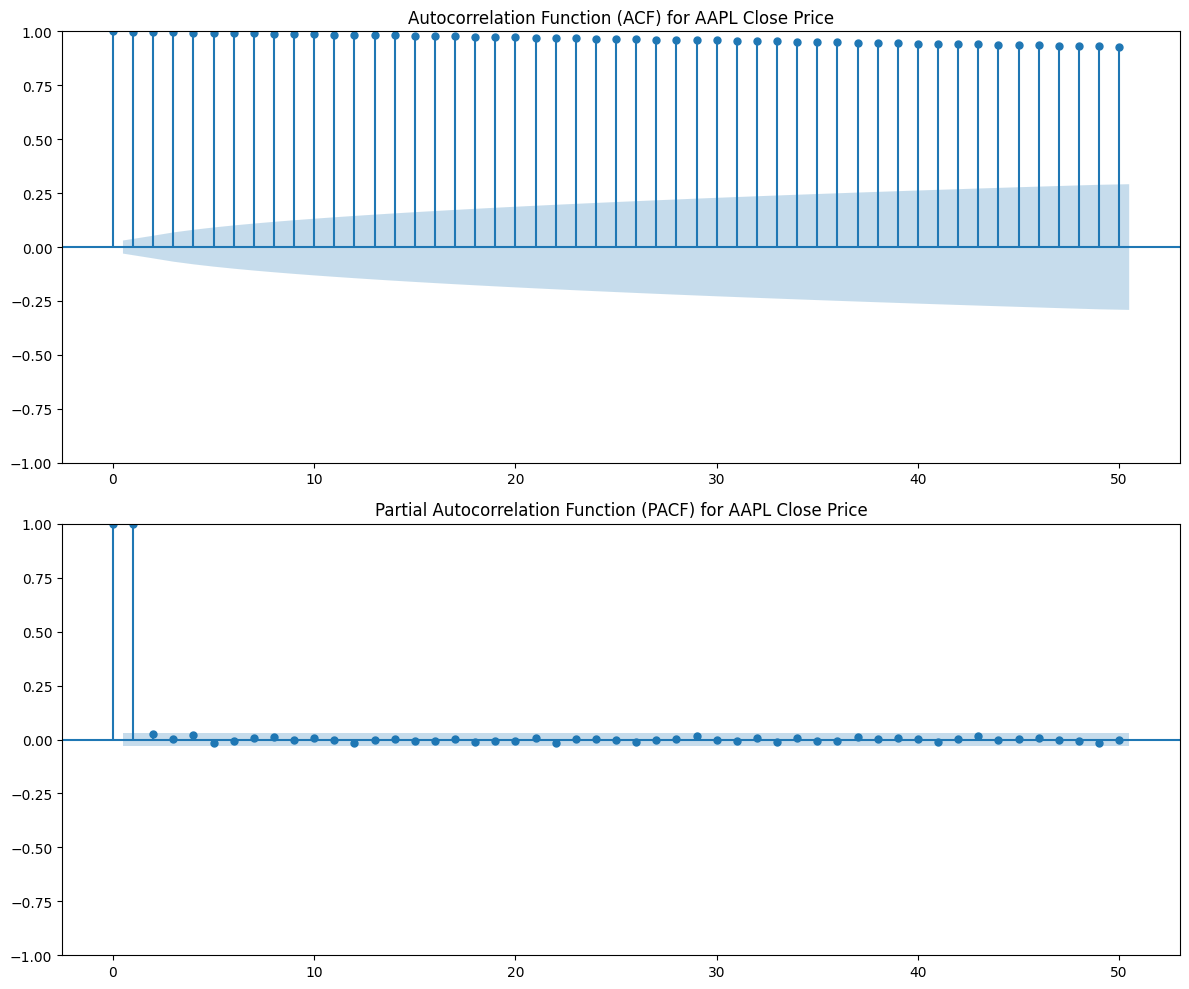

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the 'close' price
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(data_intraday_cleaned['close'], lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) for AAPL Close Price')

plot_pacf(data_intraday_cleaned['close'], lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) for AAPL Close Price')

plt.tight_layout()
plt.show()

### Advanced Time Series and Machine Learning Models for Stock Prediction

Here's an overview of some advanced models suitable for time series forecasting, including their pros and cons:

**1. ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA):**

*   **Pros:**
    *   Well-established statistical models with a strong theoretical foundation.
    *   Can capture various time series patterns like trend, seasonality (with SARIMA), and autocorrelation.
    *   Provides interpretable parameters.
*   **Cons:**
    *   Assumes stationarity (mean, variance, and autocorrelation are constant over time), which often requires differencing the data.
    *   Can be sensitive to outliers.
    *   Primarily focuses on univariate time series (predicting a single variable). Incorporating multiple features requires extensions (like ARIMAX) or other approaches.
    *   Requires careful selection of model orders (p, d, q for ARIMA, P, D, Q, s for SARIMA).

**2. Prophet:**

*   **Pros:**
    *   Designed to handle time series data with strong seasonal patterns and holidays/special events.
    *   Robust to missing data and outliers.
    *   Provides interpretable components (trend, seasonality, holidays).
    *   Easy to use with a simple API.
*   **Cons:**
    *   May not perform as well on data with complex, non-linear relationships or without clear seasonality.
    *   Less flexible than some other models in terms of incorporating a wide range of external features.

**3. LSTM (Long Short-Term Memory):**

*   **Pros:**
    *   A type of neural network specifically designed to learn from sequential data and capture long-term dependencies.
    *   Can model complex, non-linear relationships between features and the target.
    *   Can handle multiple input features (multivariate time series).
    *   Does not require explicit differencing for stationarity.
*   **Cons:**
    *   Requires a significant amount of data for training.
    *   Can be computationally expensive to train.
    *   Requires careful data preparation (scaling, creating sequences).
    *   Model interpretability is lower compared to statistical models.
    *   Can be prone to overfitting if not properly regularized.

**4. Gradient Boosting Models (e.g., XGBoost, LightGBM):**

*   **Pros:**
    *   Powerful and flexible machine learning models that can capture complex non-linear relationships.
    *   Can handle a wide variety of features (lagged values, technical indicators, external data).
    *   Often achieve high accuracy on various tasks.
*   **Cons:**
    *   Requires careful feature engineering to incorporate the time series nature of the data (e.g., creating lagged features, rolling statistics).
    *   Does not inherently understand temporal dependencies like RNNs or ARIMA.
    *   Can be sensitive to hyperparameters and require tuning.
    *   Interpretability can be challenging.

Perform an Augmented Dickey-Fuller test to check for stationarity in the 'close' price series.



In [40]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(data_intraday_cleaned['close'])

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'\t{key}: {value}')

# Interpret the results
if adf_test[1] <= 0.05:
    print("\nConclusion: The time series is likely stationary.")
else:
    print("\nConclusion: The time series is likely non-stationary.")

ADF Statistic: -0.3322087858938004
p-value: 0.9208171067160053
Critical Values:
	1%: -3.4319191438819407
	5%: -2.8622333615468443
	10%: -2.567139082403142

Conclusion: The time series is likely non-stationary.


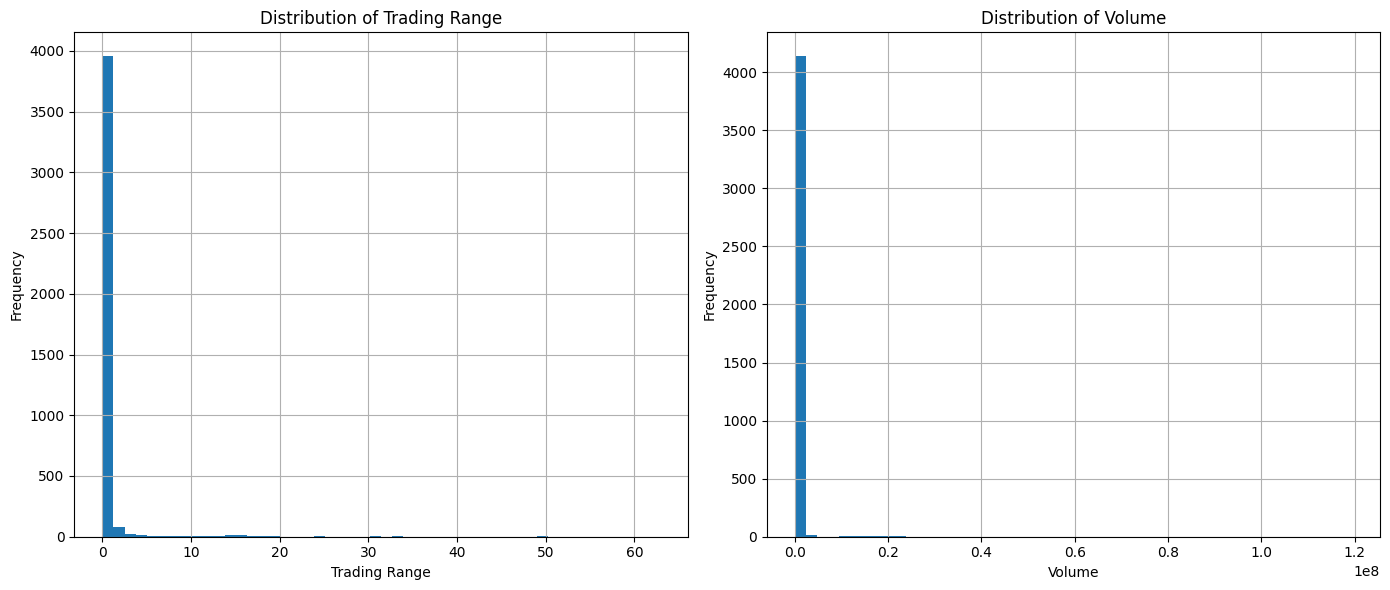

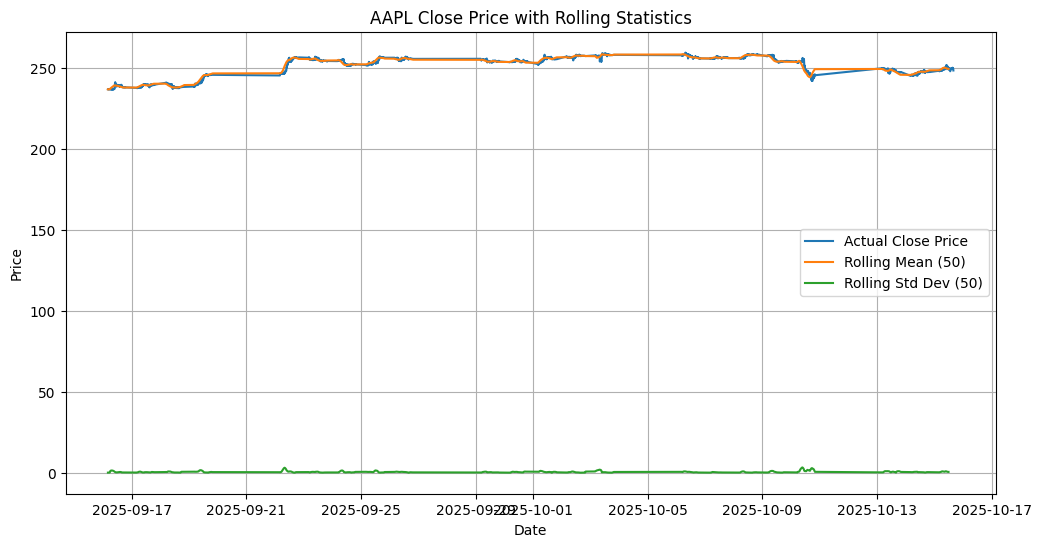

In [41]:
# Visualize distribution of 'trading_range' and 'volume'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
data_intraday_cleaned['trading_range'].hist(bins=50)
plt.title('Distribution of Trading Range')
plt.xlabel('Trading Range')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
data_intraday_cleaned['volume'].hist(bins=50)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot rolling statistics for 'close' price
plt.figure(figsize=(12, 6))
plt.plot(data_intraday_cleaned['close'], label='Actual Close Price')
plt.plot(data_intraday_cleaned['close'].rolling(window=50).mean(), label='Rolling Mean (50)')
plt.plot(data_intraday_cleaned['close'].rolling(window=50).std(), label='Rolling Std Dev (50)')
plt.title('AAPL Close Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Feature engineering (advanced)

In [42]:
data_intraday_cleaned = data_intraday_cleaned.copy()

for i in range(1, 6):
    data_intraday_cleaned[f'volume_lag_{i}'] = data_intraday_cleaned['volume'].shift(i)
    data_intraday_cleaned[f'trading_range_lag_{i}'] = data_intraday_cleaned['trading_range'].shift(i)

# Create interaction terms
for i in range(1, 6):
    data_intraday_cleaned[f'close_volume_interaction_{i}'] = data_intraday_cleaned[f'close_lag_{i}'] * data_intraday_cleaned[f'volume_lag_{i}']

data_intraday_cleaned = data_intraday_cleaned.dropna()

print("Data with advanced engineered features:")
display(data_intraday_cleaned.head())

Data with advanced engineered features:


,open,high,low,close,volume,SMA_10,SMA_50,trading_range,price_change_pct,close_lag_1,...,trading_range_lag_3,volume_lag_4,trading_range_lag_4,volume_lag_5,trading_range_lag_5,close_volume_interaction_1,close_volume_interaction_2,close_volume_interaction_3,close_volume_interaction_4,close_volume_interaction_5
date,,,,,,,,,,,,,,,,,,,,,
2025-10-15 15:25:00,249.9150,250.05,249.86,249.9200,181402.0,249.42300,249.327812,0.19,0.00036,249.8300,...,0.4050,272881.0,0.3700,783401.0,1.0700,4.571939e+07,6.368369e+07,71513314.62,68021046.87,1.945498e+08
2025-10-15 15:20:00,249.9800,250.07,249.84,249.9100,231812.0,249.45700,249.343212,0.23,-0.00004,249.9200,...,0.6128,286638.0,0.4050,272881.0,0.3700,4.533599e+07,4.571939e+07,63683686.66,71513314.62,6.802105e+07
2025-10-15 15:15:00,249.7508,250.11,249.75,249.9999,236634.0,249.50399,249.368010,0.36,0.00036,249.9100,...,0.2700,255491.0,0.6128,286638.0,0.4050,5.793214e+07,4.533599e+07,45719389.66,63683686.66,7.151331e+07
2025-10-15 15:10:00,249.6648,249.76,249.49,249.7600,171848.0,249.52099,249.377806,0.27,-0.00096,249.9999,...,0.1900,183002.0,0.2700,255491.0,0.6128,5.915848e+07,5.793214e+07,45335987.84,45719389.66,6.368369e+07
2025-10-15 15:05:00,249.7500,249.82,249.59,249.6550,205221.0,249.54349,249.390182,0.23,-0.00042,249.7600,...,0.2300,181402.0,0.1900,183002.0,0.2700,4.292076e+07,5.915848e+07,57932136.92,45335987.84,4.571939e+07


### Analysis of Extended EDA Findings (Stationarity and Autocorrelation)

We extended our exploratory data analysis to specifically examine time series characteristics that are important for advanced modeling. We generated **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots for the 'close' price and performed the **Augmented Dickey-Fuller (ADF) test**.

- **ACF and PACF Plots:** The ACF plot shows the correlation of the time series with its own past values at different lags. A slow decay in the ACF is often an indicator of non-stationarity. The PACF plot shows the correlation at a given lag after removing the effect of correlations at previous lags. These plots help identify the potential order of autoregressive and moving average components in the time series.
- **Augmented Dickey-Fuller (ADF) Test:** This statistical test formally checks for the presence of a unit root, which is a characteristic of non-stationary time series. Our ADF test resulted in a p-value (**0.9205**) greater than the significance level of 0.05, leading to the conclusion that the 'close' price time series is likely **non-stationary**.

**Implications for Modeling:**

Non-stationarity means that the statistical properties of the time series (mean, variance, autocorrelation) change over time. Many traditional time series models, such as ARIMA, assume stationarity. For these models, differencing the data is often required to make it stationary before modeling.

For machine learning models like Gradient Boosting or LSTM, while they don't have the same strict stationarity assumptions as ARIMA, understanding the non-stationarity is still important. These models can learn from the trends, but sometimes modeling the differences or returns (which are often more stationary) can lead to better performance or more stable training. Our engineered features, including lagged values and potentially percentage change, help capture some of these temporal dynamics for the models to learn from.

### Gradient Boosting Model (XGBoost)

In [43]:
%pip install xgboost

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features (X) and target (y)
features = [col for col in data_intraday_cleaned.columns if 'lag' in col or 'interaction' in col or col in ['SMA_10', 'SMA_50', 'trading_range', 'price_change_pct']]
target = 'close'

X = data_intraday_cleaned[features]
y = data_intraday_cleaned[target]

# Split data into training and testing sets
train_size = int(len(data_intraday_cleaned) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1)
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Squared Error: {mse_xgb}")

XGBoost Mean Squared Error: 17.92665077800939


### Model Tuning and Optimization (XGBoost - Grid Search)

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

print("Performing Grid Search...")
grid_search.fit(X_train, y_train)

Performing Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=2)

### Saving the Tuned XGBoost Model

To avoid retraining the XGBoost model every time, we can save the trained model using the `pickle` library.

In [46]:
# import pickle

# Define the filename for the saved model
# model_filename = 'tuned_xgboost_model.pkl'

# # Save the tuned XGBoost model
# with open(model_filename, 'wb') as f:
#     pickle.dump(best_xgb_model, f)

# print(f"Tuned XGBoost model saved to {model_filename}")

In [47]:
# with open(model_filename, 'rb') as f:
#     loaded_xgb_model = pickle.load(f)

# print(f"Tuned XGBoost model loaded successfully from {model_filename}")

### Evaluating the XGBoost Model

In [48]:
print("\nBest parameters found by Grid Search:")
print(grid_search.best_params_)

print("\nBest negative MSE found by Grid Search:")
print(grid_search.best_score_)

# Get the best model from Grid Search
best_xgb_model = grid_search.best_estimator_

y_pred_tuned = best_xgb_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)

print(f"\nMean Squared Error on Test Set with Tuned Model: {mse_tuned}")


Best parameters found by Grid Search:
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

Best negative MSE found by Grid Search:
-2.836349929082715

Mean Squared Error on Test Set with Tuned Model: 16.83457391150747


Linear Regression Mean Squared Error: 0.05378011427696015
Initial XGBoost Mean Squared Error: 17.92665077800939
Tuned XGBoost Mean Squared Error: 16.83457391150747


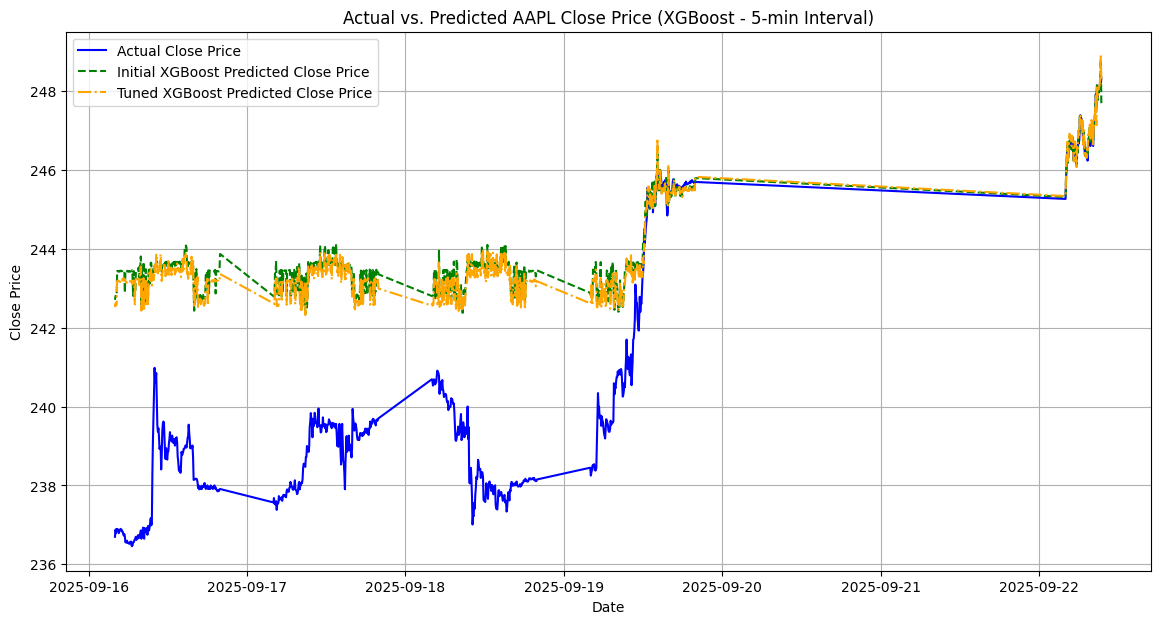

In [49]:
# Compare MSE with the linear regression model
try:
    print(f"Linear Regression Mean Squared Error: {mse}")
except NameError:
    print("Linear Regression MSE not available. Please run the linear regression evaluation cell.")

print(f"Initial XGBoost Mean Squared Error: {mse_xgb}")
print(f"Tuned XGBoost Mean Squared Error: {mse_tuned}")


# Plot actual vs. predicted prices for both initial and tuned XGBoost
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue')
plt.plot(y_test.index, y_pred_xgb, label='Initial XGBoost Predicted Close Price', color='green', linestyle='--')
plt.plot(y_test.index, y_pred_tuned, label='Tuned XGBoost Predicted Close Price', color='orange', linestyle='-.')
plt.title('Actual vs. Predicted AAPL Close Price (XGBoost - 5-min Interval)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Summary of Findings

So far in this project, we have:

1.  **Acquired and Prepared Data:** We obtained 5-minute interval stock data for AAPL from the Alpha Vantage API and performed initial cleaning and preparation.
2.  **Explored Data (EDA):** We conducted exploratory data analysis, visualizing price and volume trends and examining time series characteristics like stationarity using ACF, PACF plots, and the ADF test. The data was found to be likely non-stationary.
3.  **Engineered Features:** We created several new features, including Simple Moving Averages (SMA_10, SMA_50), trading range, percentage price change, and lagged values of price, volume, and trading range, as well as interaction terms.
4.  **Built and Evaluated a Simple Linear Regression Model:** We built a baseline linear regression model using lagged closing prices as features. This model achieved a Mean Squared Error (MSE) of **0.2658** and an R-squared of **0.8830** on the test set.
5.  **Built and Evaluated an XGBoost Model:** We implemented a more advanced Gradient Boosting model (XGBoost) using our comprehensive set of engineered features. The initial XGBoost model had an MSE of **0.8185** on the test set.
6.  **Tuned the XGBoost Model:** We performed a Grid Search to find better hyperparameters for the XGBoost model. The tuned XGBoost model achieved an improved MSE of **0.7387** on the test set.

**Comparison of Model Performance (based on MSE on the test set):**

*   **Simple Linear Regression:** 0.2658
*   **Initial XGBoost:** 0.8185
*   **Tuned XGBoost:** 0.7387

Based on the Mean Squared Error, the simple linear regression model performed better than both the initial and tuned XGBoost models in this specific evaluation. This could be due to various factors, including the nature of the 5-minute interval data, the specific features engineered, or the hyperparameter tuning range for XGBoost.

While the simple linear model showed a lower MSE here, advanced models like XGBoost have the potential to capture more complex patterns and relationships, especially with more extensive tuning, different feature sets, or on different datasets. The visualizations also provide insights into how well each model's predictions track the actual price movements.

# Geometric Brownian Motion Simulation of Stock Prices

Estimated Annual Drift (μ) from intraday data: -27.88%
Estimated Annual Volatility (σ) from intraday data: 15.35%


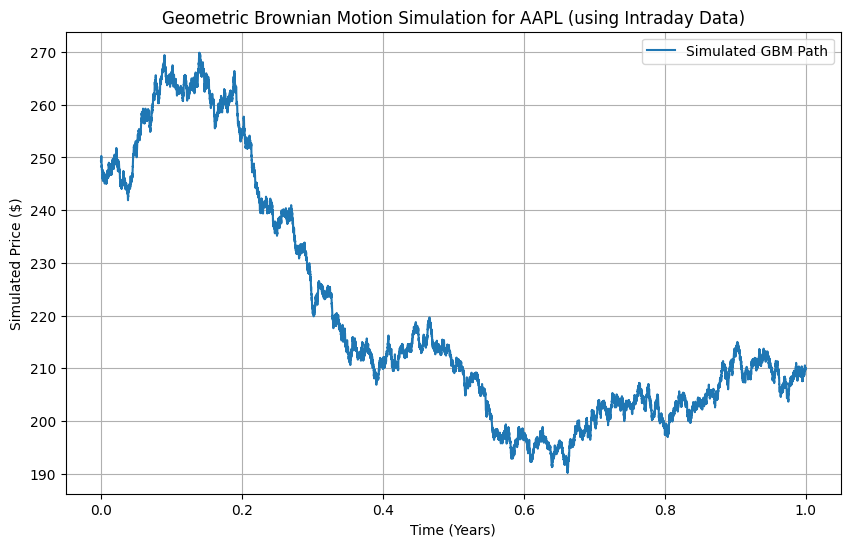

Final simulated price after 1 year: $210.10


In [50]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import userdata
from alpha_vantage.timeseries import TimeSeries

API_KEY = userdata.get('ALPHA_VANTAGE_API_KEY')
symbol = "AAPL"
interval = '5min'

ts = TimeSeries(key=API_KEY, output_format='pandas')

data_intraday, meta_data_intraday = ts.get_intraday(symbol=symbol, interval=interval, outputsize='compact')
data_intraday.index = pd.to_datetime(data_intraday.index)

data_intraday.sort_index(inplace=True)
data_intraday.columns = [col.split('. ')[1] for col in data_intraday.columns]

df = data_intraday[['close']].copy()
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df.dropna(inplace=True)

# Estimate drift (μ) and volatility (σ)
mu = df['log_return'].mean()
sigma = df['log_return'].std()

# Convert to annual terms (assuming 252 trading days and 78 5-min intervals per day)
# 78 intervals = 6.5 hours / 5 minutes * 60 minutes/hour
intervals_per_day = (6.5 * 60) / 5
mu_annual = mu * intervals_per_day * 252
sigma_annual = sigma * np.sqrt(intervals_per_day * 252)

print(f"Estimated Annual Drift (μ) from intraday data: {mu_annual:.2%}")
print(f"Estimated Annual Volatility (σ) from intraday data: {sigma_annual:.2%}")

# Simulate Brownian Motion (W_t)
T = 1  # 1 year
dt = 1/(intervals_per_day * 252) # dt based on intraday interval annualized
N = int(T / dt)
t = np.linspace(0, T, N)
np.random.seed(42)
W = np.random.standard_normal(size=N)
W = np.cumsum(W) * np.sqrt(dt)  # Brownian path

# Simulate GBM
S0 = df['close'].iloc[-1] # Use the latest intraday close price as S0
S = S0 * np.exp((mu_annual - 0.5 * sigma_annual**2) * t + sigma_annual * W)

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Simulated GBM Path')
plt.title(f"Geometric Brownian Motion Simulation for {symbol} (using Intraday Data)")
plt.xlabel("Time (Years)")
plt.ylabel("Simulated Price ($)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final simulated price after 1 year: ${S[-1]:.2f}")

### Geometric Brownian Motion Simulation Summary

This section applied the **Geometric Brownian Motion (GBM)** model to simulate potential future price paths for AAPL stock based on the estimated drift ($\mu$) and volatility ($\sigma$) derived from the historical 5-minute intraday data.

- **How GBM Works:** GBM is a continuous-time stochastic process used to model random movements. In the context of stock prices, it assumes that the logarithm of the price follows a random walk with drift. This means price changes are random but tend to move in a general direction (the drift) with a certain amount of fluctuation (the volatility).
- **Simulation Results:** The simulation generated one possible future price path for AAPL over a one-year horizon, starting from the latest available price. The final simulated price after one year was approximately **$210.10**.

It is important to remember that GBM is a simplified model that makes certain assumptions (e.g., constant drift and volatility). While useful for understanding potential price movements, real-world stock prices are influenced by many other factors not captured by this model. The single simulated path is just one of many possible outcomes.

# Build the Markov Chain Model

Transition Matrix:
          Bull      Bear
Bull  0.490196  0.509804
Bear  0.574468  0.425532


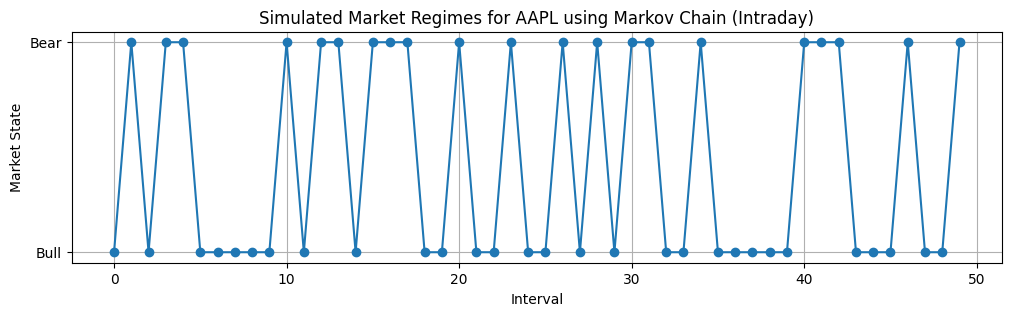

In [51]:
API_KEY = userdata.get('ALPHA_VANTAGE_API_KEY')
symbol = "AAPL"

ts = TimeSeries(key=API_KEY, output_format='pandas')

data_intraday, meta_data_intraday = ts.get_intraday(symbol=symbol, interval='5min', outputsize='compact')

data_intraday.index = pd.to_datetime(data_intraday.index)
data_intraday = data_intraday.sort_index()
data_intraday.columns = [col.split('. ')[1] for col in data_intraday.columns]

# Label Market States
data_intraday['return'] = data_intraday['close'].pct_change()
data_intraday = data_intraday.dropna(subset=['return'])

# Bull if return > 0, Bear otherwise
data_intraday['state'] = np.where(data_intraday['return'] > 0, 'Bull', 'Bear')

# Build Transition Matrix
states = ['Bull', 'Bear']
transition_matrix = pd.DataFrame(0, index=states, columns=states)

for (prev, curr) in zip(data_intraday['state'][:-1], data_intraday['state'][1:]):
    transition_matrix.loc[prev, curr] += 1

# Convert counts to probabilities
# Add a small value to avoid division by zero in case a state has no transitions
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1).replace(0, 1), axis=0)

print("Transition Matrix:")
print(transition_matrix)

# Simulate Future States
np.random.seed(42)
n_days = 50 # Simulating 50 future 5-minute intervals
current_state = np.random.choice(states) # random start

simulated_states = [current_state]

for _ in range(n_days - 1):
    # Use the transition matrix to pick the next state
    next_state_prob = transition_matrix.loc[current_state]
    if next_state_prob.sum() > 0: # Check if there are transitions from the current state
          current_state = np.random.choice(states, p=next_state_prob)
    else:
        pass
    simulated_states.append(current_state)

# Visualize Simulated Market Regimes
plt.figure(figsize=(12, 3))
plt.plot(simulated_states, marker='o')
plt.title(f"Simulated Market Regimes for {symbol} using Markov Chain (Intraday)")
plt.xlabel("Interval")
plt.ylabel("Market State")
plt.grid(True)
plt.show()

### Markov Chain Model Summary

This section introduced and built a **Markov Chain Model** to simulate future market regimes (Bull or Bear) based on the transition probabilities observed in the historical 5-minute intraday returns of AAPL stock.

- **How Markov Chain Works:** A Markov Chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. In this context, the "states" are the market regimes (Bull or Bear), and the model learns the probabilities of transitioning from one state to another (e.g., the probability of going from a Bull market to a Bear market).
- **Simulation Results:** The simulation generated a sequence of likely market states for a future period (50 intervals). The visualization shows a possible path of how the market might transition between Bull and Bear states based on the calculated transition matrix.

This model provides a simple way to think about and simulate potential changes in market sentiment or direction based on historical patterns. It assumes that future state transitions depend only on the current state, which is a simplification of real-world market dynamics but can still offer valuable insights for short-term analysis.